In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

C:\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# 쥬피터 노트북은 따로 설치
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (C:\Anaconda3\lib\site-packages\google\protobuf\internal\__init__.py)

In [ ]:
info.splits
info.splits["train"]
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

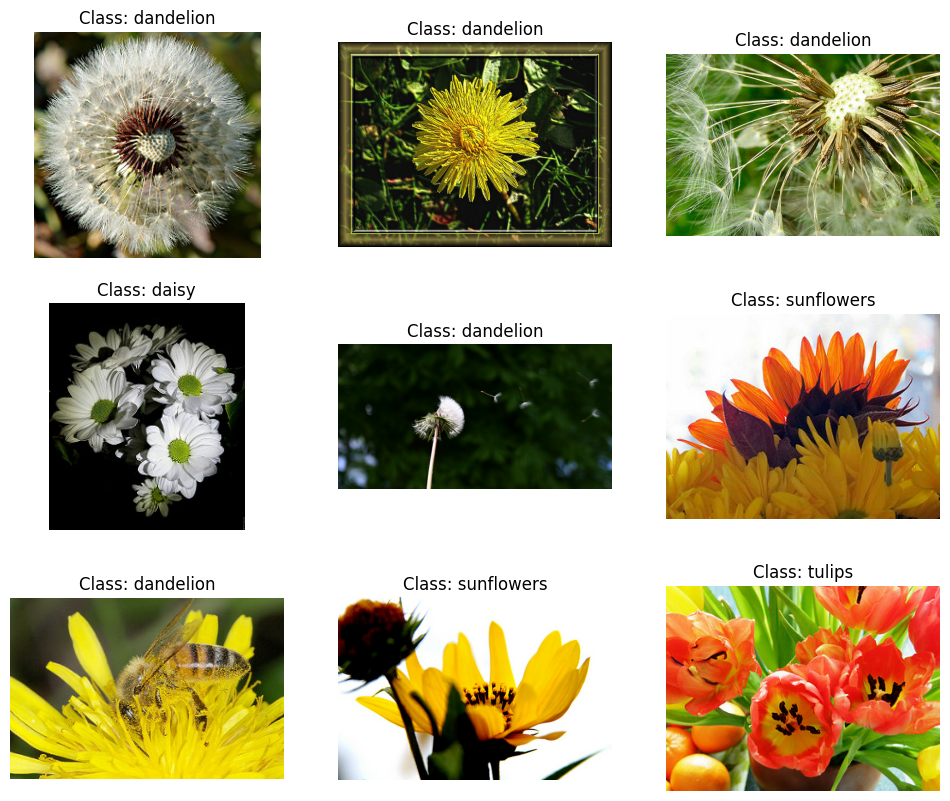

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
# 전처리
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
# 데이터셋 분리 > 전처리
from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
# 모델 다운로드
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
# 모델 Xception 컴파일
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# epoch 100회 시도
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=100, callbacks = tqdm_callback)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/86           ETA: ?s - 

Epoch 1/100
86/86 [==============================] - 15s 171ms/step - loss: 0.7490 - accuracy: 0.7882 - val_loss: 0.7118 - val_accuracy: 0.7610
Epoch 2/100


0/86           ETA: ?s - 

Epoch 2/100
86/86 [==============================] - 14s 165ms/step - loss: 0.6318 - accuracy: 0.8132 - val_loss: 0.6533 - val_accuracy: 0.7702
Epoch 3/100


0/86           ETA: ?s - 

Epoch 3/100
86/86 [==============================] - 14s 166ms/step - loss: 0.5860 - accuracy: 0.8270 - val_loss: 0.6231 - val_accuracy: 0.7702
Epoch 4/100


0/86           ETA: ?s - 

Epoch 4/100
86/86 [==============================] - 14s 164ms/step - loss: 0.5595 - accuracy: 0.8270 - val_loss: 0.6046 - val_accuracy: 0.7739
Epoch 5/100


0/86           ETA: ?s - 

Epoch 5/100
86/86 [==============================] - 14s 168ms/step - loss: 0.5393 - accuracy: 0.8347 - val_loss: 0.5898 - val_accuracy: 0.7776
Epoch 6/100


0/86           ETA: ?s - 

Epoch 6/100
86/86 [==============================] - 14s 165ms/step - loss: 0.5306 - accuracy: 0.8365 - val_loss: 0.5791 - val_accuracy: 0.7776
Epoch 7/100


0/86           ETA: ?s - 

Epoch 7/100
86/86 [==============================] - 14s 166ms/step - loss: 0.5121 - accuracy: 0.8419 - val_loss: 0.5712 - val_accuracy: 0.7868
Epoch 8/100


0/86           ETA: ?s - 

Epoch 8/100
86/86 [==============================] - 15s 170ms/step - loss: 0.5029 - accuracy: 0.8485 - val_loss: 0.5646 - val_accuracy: 0.7849
Epoch 9/100


0/86           ETA: ?s - 

Epoch 9/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4981 - accuracy: 0.8430 - val_loss: 0.5590 - val_accuracy: 0.7868
Epoch 10/100


0/86           ETA: ?s - 

Epoch 10/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4909 - accuracy: 0.8481 - val_loss: 0.5540 - val_accuracy: 0.7886
Epoch 11/100


0/86           ETA: ?s - 

Epoch 11/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4934 - accuracy: 0.8419 - val_loss: 0.5491 - val_accuracy: 0.7886
Epoch 12/100


0/86           ETA: ?s - 

Epoch 12/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4766 - accuracy: 0.8521 - val_loss: 0.5455 - val_accuracy: 0.7886
Epoch 13/100


0/86           ETA: ?s - 

Epoch 13/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4689 - accuracy: 0.8561 - val_loss: 0.5416 - val_accuracy: 0.7904
Epoch 14/100


0/86           ETA: ?s - 

Epoch 14/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4725 - accuracy: 0.8517 - val_loss: 0.5384 - val_accuracy: 0.7904
Epoch 15/100


0/86           ETA: ?s - 

Epoch 15/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4698 - accuracy: 0.8514 - val_loss: 0.5353 - val_accuracy: 0.7923
Epoch 16/100


0/86           ETA: ?s - 

Epoch 16/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4627 - accuracy: 0.8579 - val_loss: 0.5331 - val_accuracy: 0.7941
Epoch 17/100


0/86           ETA: ?s - 

Epoch 17/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4675 - accuracy: 0.8547 - val_loss: 0.5307 - val_accuracy: 0.7941
Epoch 18/100


0/86           ETA: ?s - 

Epoch 18/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4664 - accuracy: 0.8576 - val_loss: 0.5283 - val_accuracy: 0.7941
Epoch 19/100


0/86           ETA: ?s - 

Epoch 19/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4599 - accuracy: 0.8586 - val_loss: 0.5264 - val_accuracy: 0.7960
Epoch 20/100


0/86           ETA: ?s - 

Epoch 20/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4545 - accuracy: 0.8579 - val_loss: 0.5247 - val_accuracy: 0.7996
Epoch 21/100


0/86           ETA: ?s - 

Epoch 21/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4530 - accuracy: 0.8583 - val_loss: 0.5230 - val_accuracy: 0.7978
Epoch 22/100


0/86           ETA: ?s - 

Epoch 22/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4535 - accuracy: 0.8550 - val_loss: 0.5213 - val_accuracy: 0.7996
Epoch 23/100


0/86           ETA: ?s - 

Epoch 23/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4493 - accuracy: 0.8565 - val_loss: 0.5196 - val_accuracy: 0.7996
Epoch 24/100


0/86           ETA: ?s - 

Epoch 24/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4474 - accuracy: 0.8634 - val_loss: 0.5182 - val_accuracy: 0.8051
Epoch 25/100


0/86           ETA: ?s - 

Epoch 25/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4429 - accuracy: 0.8630 - val_loss: 0.5169 - val_accuracy: 0.8051
Epoch 26/100


0/86           ETA: ?s - 

Epoch 26/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4466 - accuracy: 0.8572 - val_loss: 0.5155 - val_accuracy: 0.8070
Epoch 27/100


0/86           ETA: ?s - 

Epoch 27/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4481 - accuracy: 0.8619 - val_loss: 0.5141 - val_accuracy: 0.8051
Epoch 28/100


0/86           ETA: ?s - 

Epoch 28/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4432 - accuracy: 0.8590 - val_loss: 0.5130 - val_accuracy: 0.8051
Epoch 29/100


0/86           ETA: ?s - 

Epoch 29/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4384 - accuracy: 0.8666 - val_loss: 0.5121 - val_accuracy: 0.8070
Epoch 30/100


0/86           ETA: ?s - 

Epoch 30/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4443 - accuracy: 0.8561 - val_loss: 0.5108 - val_accuracy: 0.8051
Epoch 31/100


0/86           ETA: ?s - 

Epoch 31/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4413 - accuracy: 0.8601 - val_loss: 0.5097 - val_accuracy: 0.8070
Epoch 32/100


0/86           ETA: ?s - 

Epoch 32/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4360 - accuracy: 0.8677 - val_loss: 0.5088 - val_accuracy: 0.8070
Epoch 33/100


0/86           ETA: ?s - 

Epoch 33/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4364 - accuracy: 0.8648 - val_loss: 0.5078 - val_accuracy: 0.8070
Epoch 34/100


0/86           ETA: ?s - 

Epoch 34/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4363 - accuracy: 0.8645 - val_loss: 0.5068 - val_accuracy: 0.8070
Epoch 35/100


0/86           ETA: ?s - 

Epoch 35/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4347 - accuracy: 0.8641 - val_loss: 0.5060 - val_accuracy: 0.8070
Epoch 36/100


0/86           ETA: ?s - 

Epoch 36/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4273 - accuracy: 0.8681 - val_loss: 0.5052 - val_accuracy: 0.8070
Epoch 37/100


0/86           ETA: ?s - 

Epoch 37/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4319 - accuracy: 0.8605 - val_loss: 0.5044 - val_accuracy: 0.8070
Epoch 38/100


0/86           ETA: ?s - 

Epoch 38/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4305 - accuracy: 0.8666 - val_loss: 0.5038 - val_accuracy: 0.8070
Epoch 39/100


0/86           ETA: ?s - 

Epoch 39/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4367 - accuracy: 0.8601 - val_loss: 0.5030 - val_accuracy: 0.8070
Epoch 40/100


0/86           ETA: ?s - 

Epoch 40/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4325 - accuracy: 0.8641 - val_loss: 0.5022 - val_accuracy: 0.8070
Epoch 41/100


0/86           ETA: ?s - 

Epoch 41/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4270 - accuracy: 0.8677 - val_loss: 0.5015 - val_accuracy: 0.8088
Epoch 42/100


0/86           ETA: ?s - 

Epoch 42/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4294 - accuracy: 0.8634 - val_loss: 0.5009 - val_accuracy: 0.8088
Epoch 43/100


0/86           ETA: ?s - 

Epoch 43/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4298 - accuracy: 0.8608 - val_loss: 0.5001 - val_accuracy: 0.8088
Epoch 44/100


0/86           ETA: ?s - 

Epoch 44/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4264 - accuracy: 0.8659 - val_loss: 0.4996 - val_accuracy: 0.8088
Epoch 45/100


0/86           ETA: ?s - 

Epoch 45/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4265 - accuracy: 0.8659 - val_loss: 0.4989 - val_accuracy: 0.8088
Epoch 46/100


0/86           ETA: ?s - 

Epoch 46/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4245 - accuracy: 0.8685 - val_loss: 0.4983 - val_accuracy: 0.8088
Epoch 47/100


0/86           ETA: ?s - 

Epoch 47/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4197 - accuracy: 0.8674 - val_loss: 0.4977 - val_accuracy: 0.8088
Epoch 48/100


0/86           ETA: ?s - 

Epoch 48/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4210 - accuracy: 0.8685 - val_loss: 0.4971 - val_accuracy: 0.8088
Epoch 49/100


0/86           ETA: ?s - 

Epoch 49/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4215 - accuracy: 0.8717 - val_loss: 0.4965 - val_accuracy: 0.8088
Epoch 50/100


0/86           ETA: ?s - 

Epoch 50/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4236 - accuracy: 0.8601 - val_loss: 0.4961 - val_accuracy: 0.8088
Epoch 51/100


0/86           ETA: ?s - 

Epoch 51/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4126 - accuracy: 0.8768 - val_loss: 0.4956 - val_accuracy: 0.8088
Epoch 52/100


0/86           ETA: ?s - 

Epoch 52/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4209 - accuracy: 0.8670 - val_loss: 0.4952 - val_accuracy: 0.8088
Epoch 53/100


0/86           ETA: ?s - 

Epoch 53/100
86/86 [==============================] - 14s 167ms/step - loss: 0.4159 - accuracy: 0.8714 - val_loss: 0.4947 - val_accuracy: 0.8088
Epoch 54/100


0/86           ETA: ?s - 

Epoch 54/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4226 - accuracy: 0.8685 - val_loss: 0.4943 - val_accuracy: 0.8088
Epoch 55/100


0/86           ETA: ?s - 

Epoch 55/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4202 - accuracy: 0.8659 - val_loss: 0.4938 - val_accuracy: 0.8088
Epoch 56/100


0/86           ETA: ?s - 

Epoch 56/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4273 - accuracy: 0.8692 - val_loss: 0.4932 - val_accuracy: 0.8088
Epoch 57/100


0/86           ETA: ?s - 

Epoch 57/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4177 - accuracy: 0.8677 - val_loss: 0.4928 - val_accuracy: 0.8088
Epoch 58/100


0/86           ETA: ?s - 

Epoch 58/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4180 - accuracy: 0.8656 - val_loss: 0.4923 - val_accuracy: 0.8088
Epoch 59/100


0/86           ETA: ?s - 

Epoch 59/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4143 - accuracy: 0.8695 - val_loss: 0.4919 - val_accuracy: 0.8088
Epoch 60/100


0/86           ETA: ?s - 

Epoch 60/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4148 - accuracy: 0.8703 - val_loss: 0.4915 - val_accuracy: 0.8088
Epoch 61/100


0/86           ETA: ?s - 

Epoch 61/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4187 - accuracy: 0.8656 - val_loss: 0.4911 - val_accuracy: 0.8088
Epoch 62/100


0/86           ETA: ?s - 

Epoch 62/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4181 - accuracy: 0.8706 - val_loss: 0.4907 - val_accuracy: 0.8125
Epoch 63/100


0/86           ETA: ?s - 

Epoch 63/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4182 - accuracy: 0.8645 - val_loss: 0.4903 - val_accuracy: 0.8125
Epoch 64/100


0/86           ETA: ?s - 

Epoch 64/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4149 - accuracy: 0.8743 - val_loss: 0.4900 - val_accuracy: 0.8125
Epoch 65/100


0/86           ETA: ?s - 

Epoch 65/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4147 - accuracy: 0.8721 - val_loss: 0.4894 - val_accuracy: 0.8125
Epoch 66/100


0/86           ETA: ?s - 

Epoch 66/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4179 - accuracy: 0.8677 - val_loss: 0.4891 - val_accuracy: 0.8125
Epoch 67/100


0/86           ETA: ?s - 

Epoch 67/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4189 - accuracy: 0.8630 - val_loss: 0.4887 - val_accuracy: 0.8125
Epoch 68/100


0/86           ETA: ?s - 

Epoch 68/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4129 - accuracy: 0.8717 - val_loss: 0.4883 - val_accuracy: 0.8125
Epoch 69/100


0/86           ETA: ?s - 

Epoch 69/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4168 - accuracy: 0.8648 - val_loss: 0.4880 - val_accuracy: 0.8125
Epoch 70/100


0/86           ETA: ?s - 

Epoch 70/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4109 - accuracy: 0.8717 - val_loss: 0.4877 - val_accuracy: 0.8125
Epoch 71/100


0/86           ETA: ?s - 

Epoch 71/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4175 - accuracy: 0.8717 - val_loss: 0.4873 - val_accuracy: 0.8125
Epoch 72/100


0/86           ETA: ?s - 

Epoch 72/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4072 - accuracy: 0.8739 - val_loss: 0.4869 - val_accuracy: 0.8125
Epoch 73/100


0/86           ETA: ?s - 

Epoch 73/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4140 - accuracy: 0.8743 - val_loss: 0.4866 - val_accuracy: 0.8125
Epoch 74/100


0/86           ETA: ?s - 

Epoch 74/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4121 - accuracy: 0.8695 - val_loss: 0.4862 - val_accuracy: 0.8125
Epoch 75/100


0/86           ETA: ?s - 

Epoch 75/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4152 - accuracy: 0.8695 - val_loss: 0.4859 - val_accuracy: 0.8125
Epoch 76/100


0/86           ETA: ?s - 

Epoch 76/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4041 - accuracy: 0.8779 - val_loss: 0.4856 - val_accuracy: 0.8125
Epoch 77/100


0/86           ETA: ?s - 

Epoch 77/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4098 - accuracy: 0.8732 - val_loss: 0.4853 - val_accuracy: 0.8125
Epoch 78/100


0/86           ETA: ?s - 

Epoch 78/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4053 - accuracy: 0.8735 - val_loss: 0.4851 - val_accuracy: 0.8125
Epoch 79/100


0/86           ETA: ?s - 

Epoch 79/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4107 - accuracy: 0.8688 - val_loss: 0.4847 - val_accuracy: 0.8125
Epoch 80/100


0/86           ETA: ?s - 

Epoch 80/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4107 - accuracy: 0.8692 - val_loss: 0.4845 - val_accuracy: 0.8125
Epoch 81/100


0/86           ETA: ?s - 

Epoch 81/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4052 - accuracy: 0.8779 - val_loss: 0.4842 - val_accuracy: 0.8125
Epoch 82/100


0/86           ETA: ?s - 

Epoch 82/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4013 - accuracy: 0.8761 - val_loss: 0.4839 - val_accuracy: 0.8125
Epoch 83/100


0/86           ETA: ?s - 

Epoch 83/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4064 - accuracy: 0.8703 - val_loss: 0.4837 - val_accuracy: 0.8125
Epoch 84/100


0/86           ETA: ?s - 

Epoch 84/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4018 - accuracy: 0.8794 - val_loss: 0.4834 - val_accuracy: 0.8125
Epoch 85/100


0/86           ETA: ?s - 

Epoch 85/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4060 - accuracy: 0.8699 - val_loss: 0.4831 - val_accuracy: 0.8125
Epoch 86/100


0/86           ETA: ?s - 

Epoch 86/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4024 - accuracy: 0.8695 - val_loss: 0.4829 - val_accuracy: 0.8125
Epoch 87/100


0/86           ETA: ?s - 

Epoch 87/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4136 - accuracy: 0.8717 - val_loss: 0.4826 - val_accuracy: 0.8125
Epoch 88/100


0/86           ETA: ?s - 

Epoch 88/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4035 - accuracy: 0.8681 - val_loss: 0.4823 - val_accuracy: 0.8125
Epoch 89/100


0/86           ETA: ?s - 

Epoch 89/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4093 - accuracy: 0.8703 - val_loss: 0.4821 - val_accuracy: 0.8125
Epoch 90/100


0/86           ETA: ?s - 

Epoch 90/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4000 - accuracy: 0.8757 - val_loss: 0.4818 - val_accuracy: 0.8125
Epoch 91/100


0/86           ETA: ?s - 

Epoch 91/100
86/86 [==============================] - 14s 168ms/step - loss: 0.4088 - accuracy: 0.8735 - val_loss: 0.4816 - val_accuracy: 0.8143
Epoch 92/100


0/86           ETA: ?s - 

Epoch 92/100
86/86 [==============================] - 14s 169ms/step - loss: 0.4021 - accuracy: 0.8648 - val_loss: 0.4814 - val_accuracy: 0.8143
Epoch 93/100


0/86           ETA: ?s - 

Epoch 93/100
86/86 [==============================] - 15s 172ms/step - loss: 0.4083 - accuracy: 0.8728 - val_loss: 0.4811 - val_accuracy: 0.8143
Epoch 94/100


0/86           ETA: ?s - 

Epoch 94/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4069 - accuracy: 0.8703 - val_loss: 0.4809 - val_accuracy: 0.8143
Epoch 95/100


0/86           ETA: ?s - 

Epoch 95/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4068 - accuracy: 0.8688 - val_loss: 0.4807 - val_accuracy: 0.8143
Epoch 96/100


0/86           ETA: ?s - 

Epoch 96/100
86/86 [==============================] - 15s 170ms/step - loss: 0.4051 - accuracy: 0.8739 - val_loss: 0.4805 - val_accuracy: 0.8143
Epoch 97/100


0/86           ETA: ?s - 

Epoch 97/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4051 - accuracy: 0.8743 - val_loss: 0.4802 - val_accuracy: 0.8143
Epoch 98/100


0/86           ETA: ?s - 

Epoch 98/100
86/86 [==============================] - 15s 169ms/step - loss: 0.4007 - accuracy: 0.8725 - val_loss: 0.4800 - val_accuracy: 0.8143
Epoch 99/100


0/86           ETA: ?s - 

Epoch 99/100
86/86 [==============================] - 15s 171ms/step - loss: 0.3994 - accuracy: 0.8754 - val_loss: 0.4798 - val_accuracy: 0.8162
Epoch 100/100


0/86           ETA: ?s - 

Epoch 100/100
86/86 [==============================] - 15s 171ms/step - loss: 0.4066 - accuracy: 0.8721 - val_loss: 0.4796 - val_accuracy: 0.8162


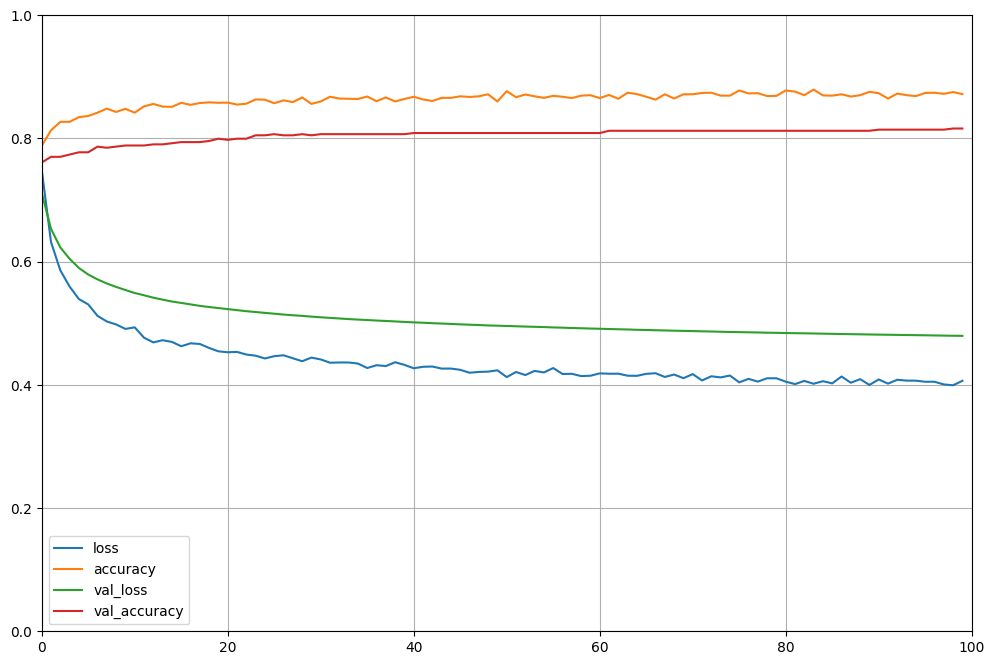

In [ ]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0,100)
plt.show()

#### object detection

In [ ]:
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
class_output= keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])

In [ ]:
model.summary()

In [ ]:
# 컴파일
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
# 학습
history = model.fit(fake_train_set, steps_per_epoch=10,
          epochs=20, callbacks = tqdm_callback)

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/10           ETA: ?s - 

Epoch 1/20
10/10 [==============================] - 2s 143ms/step - loss: 0.2014 - dense_4_loss: 0.2225 - dense_5_loss: 0.1168 - dense_4_accuracy: 0.9156 - dense_5_accuracy: 0.2625
Epoch 2/20


0/10           ETA: ?s - 

Epoch 2/20
10/10 [==============================] - 1s 139ms/step - loss: 0.1878 - dense_4_loss: 0.2053 - dense_5_loss: 0.1179 - dense_4_accuracy: 0.9406 - dense_5_accuracy: 0.2469
Epoch 3/20


0/10           ETA: ?s - 

Epoch 3/20
10/10 [==============================] - 1s 138ms/step - loss: 0.1721 - dense_4_loss: 0.1861 - dense_5_loss: 0.1160 - dense_4_accuracy: 0.9406 - dense_5_accuracy: 0.2062
Epoch 4/20


0/10           ETA: ?s - 

Epoch 4/20
10/10 [==============================] - 1s 138ms/step - loss: 0.1504 - dense_4_loss: 0.1590 - dense_5_loss: 0.1159 - dense_4_accuracy: 0.9719 - dense_5_accuracy: 0.2719
Epoch 5/20


0/10           ETA: ?s - 

Epoch 5/20
10/10 [==============================] - 1s 137ms/step - loss: 0.1749 - dense_4_loss: 0.1903 - dense_5_loss: 0.1134 - dense_4_accuracy: 0.9375 - dense_5_accuracy: 0.2688
Epoch 6/20


0/10           ETA: ?s - 

Epoch 6/20
10/10 [==============================] - 1s 139ms/step - loss: 0.1379 - dense_4_loss: 0.1432 - dense_5_loss: 0.1167 - dense_4_accuracy: 0.9563 - dense_5_accuracy: 0.2500
Epoch 7/20


0/10           ETA: ?s - 

Epoch 7/20
10/10 [==============================] - 1s 141ms/step - loss: 0.1523 - dense_4_loss: 0.1621 - dense_5_loss: 0.1130 - dense_4_accuracy: 0.9500 - dense_5_accuracy: 0.2750
Epoch 8/20


0/10           ETA: ?s - 

Epoch 8/20
10/10 [==============================] - 1s 138ms/step - loss: 0.1574 - dense_4_loss: 0.1690 - dense_5_loss: 0.1108 - dense_4_accuracy: 0.9656 - dense_5_accuracy: 0.2438
Epoch 9/20


0/10           ETA: ?s - 

Epoch 9/20
10/10 [==============================] - 1s 139ms/step - loss: 0.1861 - dense_4_loss: 0.2051 - dense_5_loss: 0.1099 - dense_4_accuracy: 0.9344 - dense_5_accuracy: 0.2438
Epoch 10/20


0/10           ETA: ?s - 

Epoch 10/20
10/10 [==============================] - 1s 139ms/step - loss: 0.1496 - dense_4_loss: 0.1594 - dense_5_loss: 0.1105 - dense_4_accuracy: 0.9469 - dense_5_accuracy: 0.2500
Epoch 11/20


0/10           ETA: ?s - 

Epoch 11/20
10/10 [==============================] - 1s 140ms/step - loss: 0.1574 - dense_4_loss: 0.1670 - dense_5_loss: 0.1186 - dense_4_accuracy: 0.9656 - dense_5_accuracy: 0.2438
Epoch 12/20


0/10           ETA: ?s - 

Epoch 12/20
10/10 [==============================] - 1s 141ms/step - loss: 0.1403 - dense_4_loss: 0.1472 - dense_5_loss: 0.1127 - dense_4_accuracy: 0.9531 - dense_5_accuracy: 0.2594
Epoch 13/20


0/10           ETA: ?s - 

Epoch 13/20
10/10 [==============================] - 1s 140ms/step - loss: 0.1504 - dense_4_loss: 0.1606 - dense_5_loss: 0.1095 - dense_4_accuracy: 0.9406 - dense_5_accuracy: 0.2500
Epoch 14/20


0/10           ETA: ?s - 

Epoch 14/20
10/10 [==============================] - 1s 140ms/step - loss: 0.1298 - dense_4_loss: 0.1351 - dense_5_loss: 0.1085 - dense_4_accuracy: 0.9688 - dense_5_accuracy: 0.2969
Epoch 15/20


0/10           ETA: ?s - 

Epoch 15/20
10/10 [==============================] - 1s 141ms/step - loss: 0.1352 - dense_4_loss: 0.1405 - dense_5_loss: 0.1138 - dense_4_accuracy: 0.9719 - dense_5_accuracy: 0.2313
Epoch 16/20


0/10           ETA: ?s - 

Epoch 16/20
10/10 [==============================] - 1s 142ms/step - loss: 0.1161 - dense_4_loss: 0.1180 - dense_5_loss: 0.1084 - dense_4_accuracy: 0.9688 - dense_5_accuracy: 0.2562
Epoch 17/20


0/10           ETA: ?s - 

Epoch 17/20
10/10 [==============================] - 1s 142ms/step - loss: 0.1282 - dense_4_loss: 0.1321 - dense_5_loss: 0.1123 - dense_4_accuracy: 0.9531 - dense_5_accuracy: 0.2375
Epoch 18/20


0/10           ETA: ?s - 

Epoch 18/20
10/10 [==============================] - 1s 141ms/step - loss: 0.1205 - dense_4_loss: 0.1235 - dense_5_loss: 0.1084 - dense_4_accuracy: 0.9656 - dense_5_accuracy: 0.2500
Epoch 19/20


0/10           ETA: ?s - 

Epoch 19/20
10/10 [==============================] - 1s 142ms/step - loss: 0.1377 - dense_4_loss: 0.1438 - dense_5_loss: 0.1132 - dense_4_accuracy: 0.9500 - dense_5_accuracy: 0.1813
Epoch 20/20


0/10           ETA: ?s - 

Epoch 20/20
10/10 [==============================] - 1s 142ms/step - loss: 0.1414 - dense_4_loss: 0.1491 - dense_5_loss: 0.1106 - dense_4_accuracy: 0.9656 - dense_5_accuracy: 0.2500


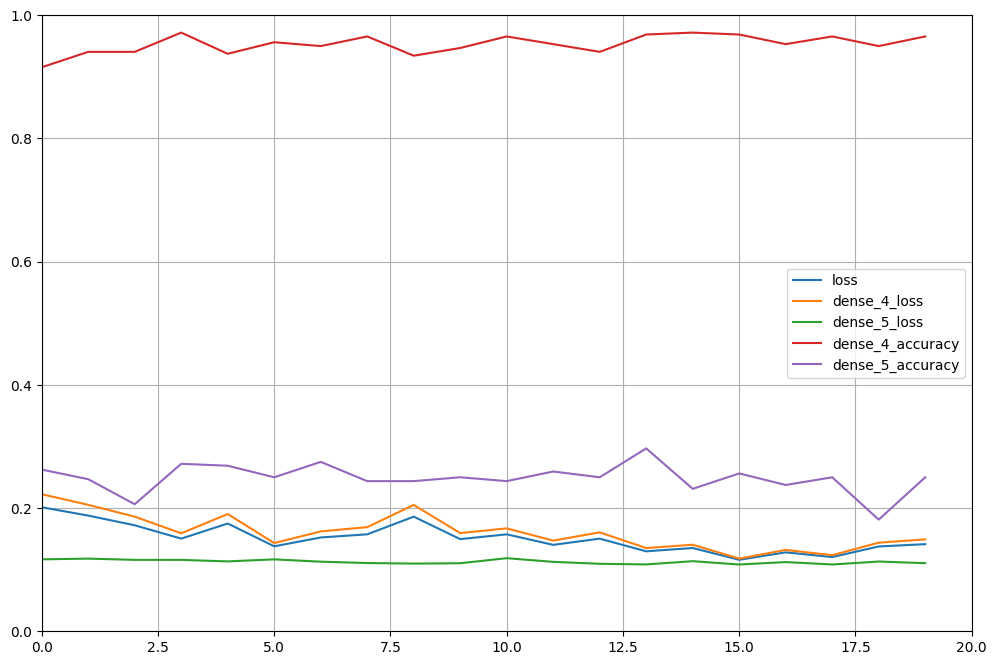

In [ ]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0,20)
plt.show()

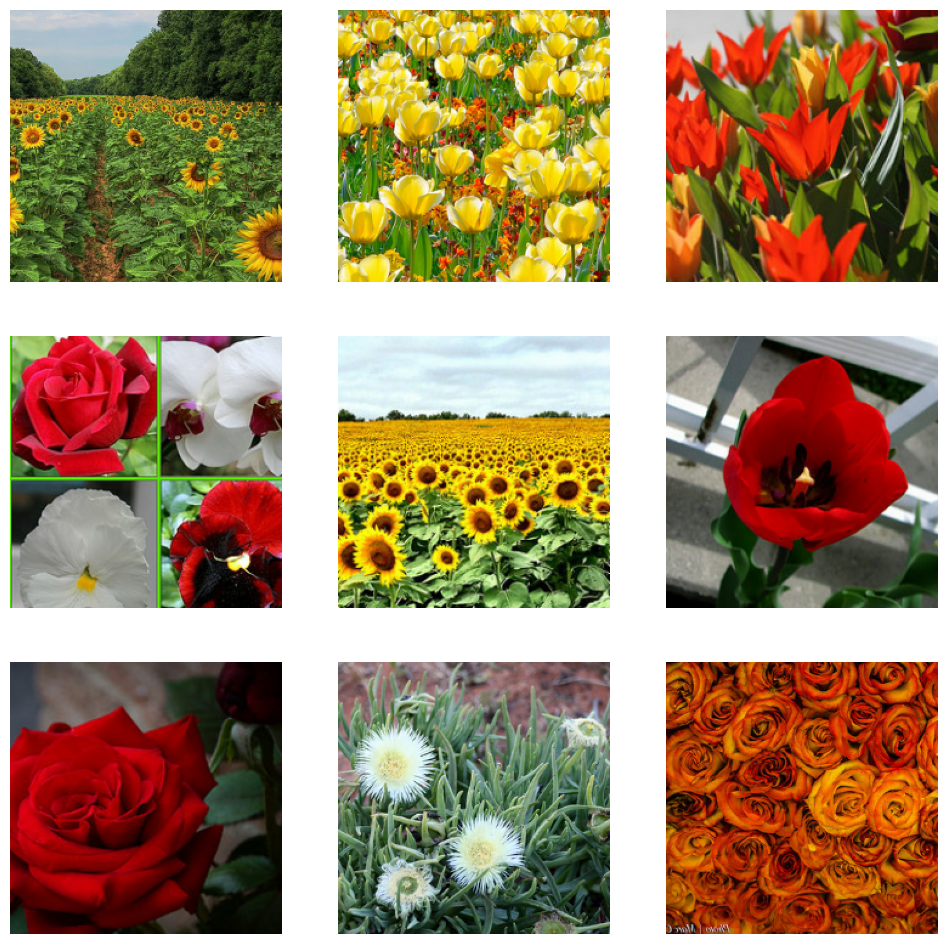

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in fake_train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.axis("off")

plt.show()


### 실험 1
* stl10 데이터셋
* Xception

In [3]:
import tensorflow_datasets as tfds

In [4]:
# 다운로드 데이터셋
dataset, info = tfds.load("uc_merced", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incompleteF6H338/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [5]:
info.splits
info.splits["train"]
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "uc_merced",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

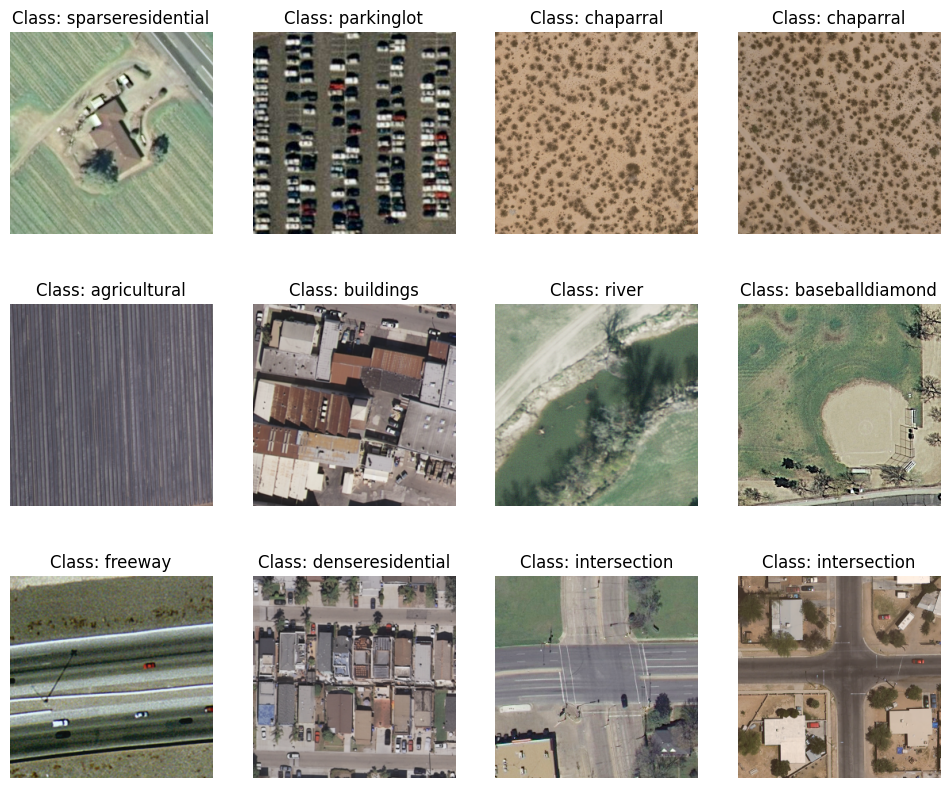

In [6]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(12):
    index += 1
    plt.subplot(3, 4, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [7]:
# 전처리
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [18]:
# 데이터셋 분리 > 전처리
from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [19]:
# 모델 다운로드
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg) # softmax
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [20]:
for layer in base_model.layers:
    layer.trainable = False
# 모델 Xception 컴파일
optimizer = keras.optimizers.Nadam(learning_rate=0.002, decay=0.004)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [21]:
# epoch 30회 시도
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=30, callbacks = tqdm_callback)

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/49           ETA: ?s - 

Epoch 1/30
49/49 [==============================] - 15s 214ms/step - loss: 1.3920 - accuracy: 0.7098 - val_loss: 0.6212 - val_accuracy: 0.8750
Epoch 2/30


0/49           ETA: ?s - 

Epoch 2/30
49/49 [==============================] - 9s 179ms/step - loss: 0.4167 - accuracy: 0.9216 - val_loss: 0.4025 - val_accuracy: 0.8958
Epoch 3/30


0/49           ETA: ?s - 

Epoch 3/30
49/49 [==============================] - 10s 209ms/step - loss: 0.2617 - accuracy: 0.9515 - val_loss: 0.3144 - val_accuracy: 0.9097
Epoch 4/30


0/49           ETA: ?s - 

Epoch 4/30
49/49 [==============================] - 9s 184ms/step - loss: 0.1830 - accuracy: 0.9681 - val_loss: 0.2812 - val_accuracy: 0.9236
Epoch 5/30


0/49           ETA: ?s - 

Epoch 5/30
49/49 [==============================] - 9s 179ms/step - loss: 0.1489 - accuracy: 0.9726 - val_loss: 0.2534 - val_accuracy: 0.9201
Epoch 6/30


0/49           ETA: ?s - 

Epoch 6/30
49/49 [==============================] - 9s 176ms/step - loss: 0.1181 - accuracy: 0.9815 - val_loss: 0.2621 - val_accuracy: 0.9028
Epoch 7/30


0/49           ETA: ?s - 

Epoch 7/30
49/49 [==============================] - 8s 173ms/step - loss: 0.1007 - accuracy: 0.9872 - val_loss: 0.2334 - val_accuracy: 0.9097
Epoch 8/30


0/49           ETA: ?s - 

Epoch 8/30
49/49 [==============================] - 8s 172ms/step - loss: 0.0877 - accuracy: 0.9866 - val_loss: 0.2132 - val_accuracy: 0.9201
Epoch 9/30


0/49           ETA: ?s - 

Epoch 9/30
49/49 [==============================] - 8s 173ms/step - loss: 0.0761 - accuracy: 0.9885 - val_loss: 0.2030 - val_accuracy: 0.9306
Epoch 10/30


0/49           ETA: ?s - 

Epoch 10/30
49/49 [==============================] - 9s 176ms/step - loss: 0.0648 - accuracy: 0.9917 - val_loss: 0.2146 - val_accuracy: 0.9097
Epoch 11/30


0/49           ETA: ?s - 

Epoch 11/30
49/49 [==============================] - 9s 182ms/step - loss: 0.0589 - accuracy: 0.9911 - val_loss: 0.2087 - val_accuracy: 0.9236
Epoch 12/30


0/49           ETA: ?s - 

Epoch 12/30
49/49 [==============================] - 9s 175ms/step - loss: 0.0487 - accuracy: 0.9974 - val_loss: 0.2089 - val_accuracy: 0.9306
Epoch 13/30


0/49           ETA: ?s - 

Epoch 13/30
49/49 [==============================] - 8s 174ms/step - loss: 0.0499 - accuracy: 0.9962 - val_loss: 0.2098 - val_accuracy: 0.9167
Epoch 14/30


0/49           ETA: ?s - 

Epoch 14/30
49/49 [==============================] - 9s 177ms/step - loss: 0.0418 - accuracy: 0.9974 - val_loss: 0.2033 - val_accuracy: 0.9340
Epoch 15/30


0/49           ETA: ?s - 

Epoch 15/30
49/49 [==============================] - 10s 202ms/step - loss: 0.0381 - accuracy: 0.9962 - val_loss: 0.2236 - val_accuracy: 0.9236
Epoch 16/30


0/49           ETA: ?s - 

Epoch 16/30
49/49 [==============================] - 10s 200ms/step - loss: 0.0351 - accuracy: 0.9968 - val_loss: 0.2047 - val_accuracy: 0.9271
Epoch 17/30


0/49           ETA: ?s - 

Epoch 17/30
49/49 [==============================] - 10s 199ms/step - loss: 0.0332 - accuracy: 0.9943 - val_loss: 0.1990 - val_accuracy: 0.9167
Epoch 18/30


0/49           ETA: ?s - 

Epoch 18/30
49/49 [==============================] - 10s 198ms/step - loss: 0.0307 - accuracy: 0.9987 - val_loss: 0.2081 - val_accuracy: 0.9236
Epoch 19/30


0/49           ETA: ?s - 

Epoch 19/30
49/49 [==============================] - 8s 174ms/step - loss: 0.0304 - accuracy: 0.9974 - val_loss: 0.1919 - val_accuracy: 0.9236
Epoch 20/30


0/49           ETA: ?s - 

Epoch 20/30
49/49 [==============================] - 10s 199ms/step - loss: 0.0281 - accuracy: 0.9962 - val_loss: 0.1953 - val_accuracy: 0.9236
Epoch 21/30


0/49           ETA: ?s - 

Epoch 21/30
49/49 [==============================] - 9s 174ms/step - loss: 0.0211 - accuracy: 0.9987 - val_loss: 0.1852 - val_accuracy: 0.9306
Epoch 22/30


0/49           ETA: ?s - 

Epoch 22/30
49/49 [==============================] - 9s 175ms/step - loss: 0.0247 - accuracy: 0.9987 - val_loss: 0.2189 - val_accuracy: 0.9236
Epoch 23/30


0/49           ETA: ?s - 

Epoch 23/30
49/49 [==============================] - 9s 176ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1820 - val_accuracy: 0.9306
Epoch 24/30


0/49           ETA: ?s - 

Epoch 24/30
49/49 [==============================] - 10s 199ms/step - loss: 0.0236 - accuracy: 0.9968 - val_loss: 0.1636 - val_accuracy: 0.9340
Epoch 25/30


0/49           ETA: ?s - 

Epoch 25/30
49/49 [==============================] - 9s 174ms/step - loss: 0.0185 - accuracy: 0.9974 - val_loss: 0.1781 - val_accuracy: 0.9340
Epoch 26/30


0/49           ETA: ?s - 

Epoch 26/30
49/49 [==============================] - 10s 200ms/step - loss: 0.0190 - accuracy: 0.9994 - val_loss: 0.1774 - val_accuracy: 0.9410
Epoch 27/30


0/49           ETA: ?s - 

Epoch 27/30
49/49 [==============================] - 10s 198ms/step - loss: 0.0213 - accuracy: 0.9987 - val_loss: 0.1680 - val_accuracy: 0.9306
Epoch 28/30


0/49           ETA: ?s - 

Epoch 28/30
49/49 [==============================] - 8s 174ms/step - loss: 0.0151 - accuracy: 0.9994 - val_loss: 0.1746 - val_accuracy: 0.9375
Epoch 29/30


0/49           ETA: ?s - 

Epoch 29/30
49/49 [==============================] - 10s 202ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.9271
Epoch 30/30


0/49           ETA: ?s - 

Epoch 30/30
49/49 [==============================] - 10s 201ms/step - loss: 0.0157 - accuracy: 0.9987 - val_loss: 0.1800 - val_accuracy: 0.9340


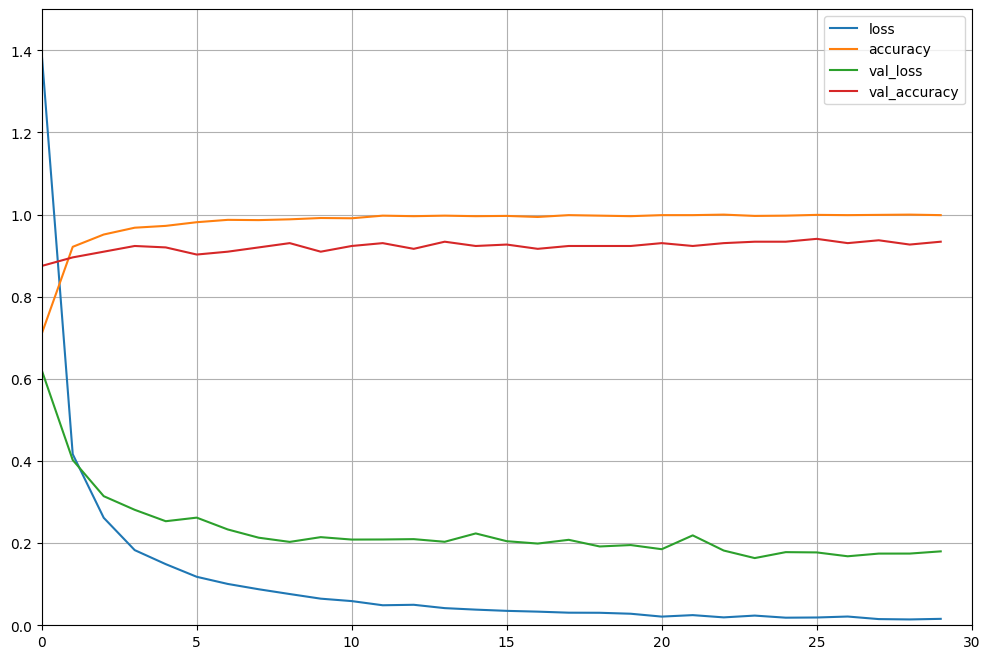

In [25]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1.5)
plt.gca().set_xlim(0,30)
plt.show()